In [41]:
%load_ext autoreload
%autoreload 2
import torch
from transformers import BertModel, DistilBertModel
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import datasets
import numpy as np
import os.path
from spacy.lang.en import English
from datasets import load_from_disk
import pickle as pkl
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
from copy import deepcopy
from tqdm import tqdm
import sys
sys.path.append('..')
import analyze_helper
import dvu
dvu.set_style()
from matplotlib.patches import Rectangle

import pandas as pd
from os.path import join as oj
import string
from typing import List
import data
import matplotlib.pyplot as plt
import seaborn as sns
import config
pd.set_option('display.max_rows', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Remember to run aggregate!!!

In [12]:
rs = pd.read_pickle(oj(config.results_dir, 'rs_vary_ngrams_test.pkl'))
# rr, r_sem = analyze_helper.average_seeds(rs)
rs.head()

,checkpoint,ngrams,ngrams_test,subsample,all,norm,dataset,seed,layer,parsing,ignore_cache,padding,dataset_key_text,num_features,acc_train,acc_val
0,nateraw/bert-base-uncased-emotion,1,1,-1,all,,emotion,1,last_hidden_state_mean,,True,True,text,768,0.907875,0.8740
1,nateraw/bert-base-uncased-emotion,1,2,-1,all,,emotion,1,last_hidden_state_mean,,True,True,text,768,0.907875,0.8460
2,nateraw/bert-base-uncased-emotion,1,3,-1,all,,emotion,1,last_hidden_state_mean,,True,True,text,768,0.907875,0.8480
3,nateraw/bert-base-uncased-emotion,1,4,-1,all,,emotion,1,last_hidden_state_mean,,True,True,text,768,0.907875,0.8510
4,nateraw/bert-base-uncased-emotion,1,5,-1,all,,emotion,1,last_hidden_state_mean,,True,True,text,768,0.907875,0.8555


# make all heatmaps

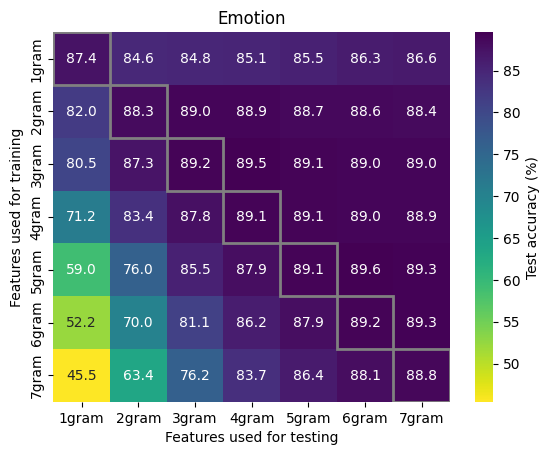

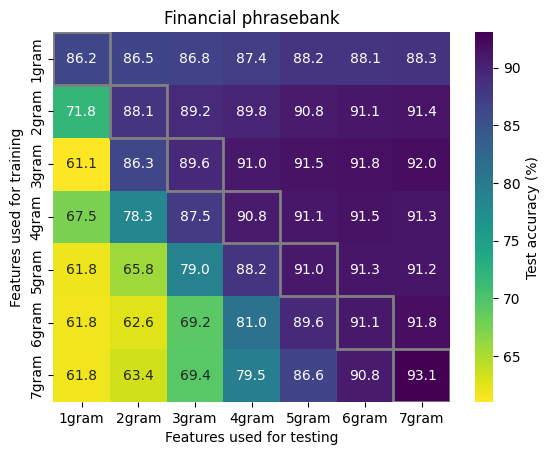

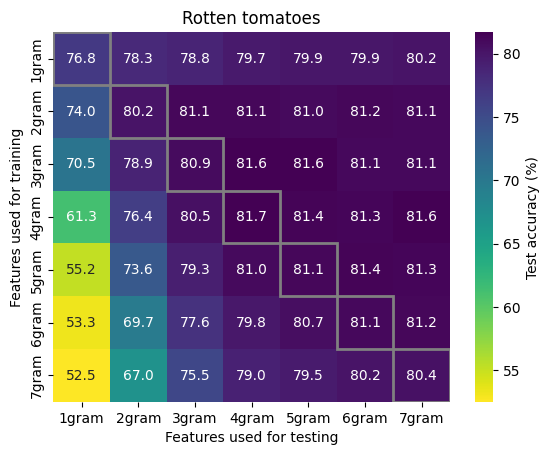

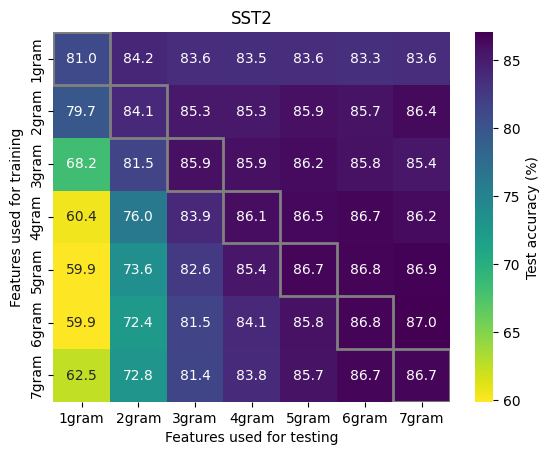

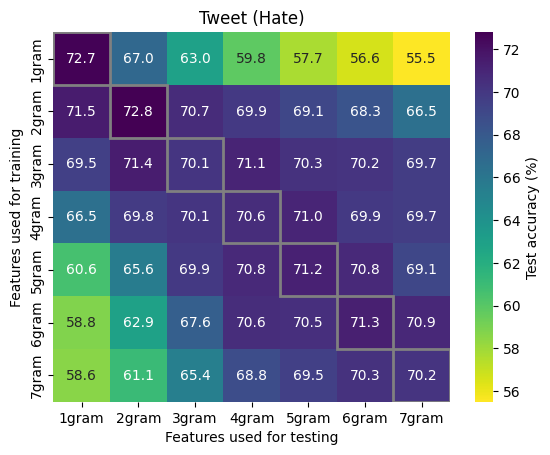

In [52]:
heatmaps = []
dsets = []
for dset in sorted(rs.dataset.unique()):
    # dset = 'sst2'
    d = rs[rs.dataset == dset]
    d[['ngrams', 'ngrams_test', 'acc_val']].head()
    N = 7
    heatmap = np.zeros((N, N))
    # plt.figure(dpi=300)
    for i in range(N):
        for j in range(N):
            row = d[
                (d.ngrams == i + 1) & (d.ngrams_test == j + 1)
            ]
            if row.shape[0] == 1:
                heatmap[i, j] = row['acc_val']
            else:
                pass

    ax = sns.heatmap(heatmap * 100, annot=True,
                fmt='.1f', cbar_kws={'label': 'Test accuracy (%)'},
                cmap=sns.color_palette("viridis_r", as_cmap=True),
                # vmin=100 * heatmap.max() - 10,
                )
    for i in range(N):
        ax.add_patch(Rectangle((i, i), 1, 1, fill=False, edgecolor='gray', lw=2))
    plt.yticks(np.arange(N) + 0.5, [f'{n + 1}gram' for n in range(N)])
    plt.xticks(np.arange(N) + 0.5, [f'{n + 1}gram' for n in range(N)])
    plt.title(data.DSETS_RENAME_DICT[dset])
    plt.ylabel('Features used for training')
    plt.xlabel('Features used for testing')
    plt.savefig(f'../{dset}.pdf', bbox_inches='tight')
    plt.show()

    dsets.append(dset)
    heatmaps.append(deepcopy(heatmap))

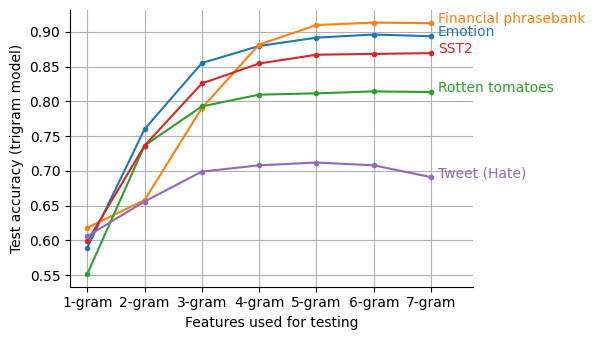

In [84]:
ngram_train = 4
plt.figure(figsize=(6, 3.5))
for i, dset in enumerate(dsets):
    plt.plot(heatmaps[i][ngram_train], '.-', label=data.DSETS_RENAME_DICT[dset])
plt.grid()
plt.xticks(np.arange(N), [f'{n + 1}-gram' for n in range(N)])
plt.ylabel('Test accuracy (trigram model)')
plt.xlabel('Features used for testing')
dvu.line_legend(fontsize='medium')
plt.savefig('../vary_ngrams_single.pdf', bbox_inches='tight')
plt.show()